In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import tensorflow as tf
import numpy as np

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
def get_non0_index_scope(l):
    """

    :param l:
    :return:
    """
    if l[0]:
        start = 0
    else:
        start = l.index(True)
    l.reverse()
    if l[0]:
        end = 0
    else:
        end = l.index(True)
    end = len(l) - end
    return start, end


def get_min_content_area(img):
    """

    :param img:
    :return:
    """
    col_proj = (np.sum(img, axis=0) != 0).tolist()
    row_proj = (np.sum(img, axis=1) != 0).tolist()
    col_start, col_end = get_non0_index_scope(col_proj)
    row_start, row_end = get_non0_index_scope(row_proj)

    return row_start, row_end, col_start, col_end


def get_resize_padding_img(img, size=None, padding=None):
    """

    :param img:
    :param size:
    :param padding:
    :return:
    """
    if size and padding:
        sub_img = cv2.resize(img, size)
        sub_img = np.pad(sub_img, padding, mode='constant')
        sub_img = np.pad(sub_img, ((3,), (3,)), mode='constant')
    else:
        sub_img = cv2.resize(img, (28, 28))
    return sub_img

In [5]:
def preprocessing(img):
    row_start, row_end, col_start, col_end = get_min_content_area(img)
    sub_img = img[row_start: row_end, col_start: col_end]
    
    if col_end - col_start < row_end - row_start:  # 铅直边较长
        change_rate = (row_end - row_start - 42) / float((row_end - row_start))
        changed_width = int((col_end - col_start) * (1 - change_rate))

        if changed_width % 2 == 1:
            changed_width += 1
        if changed_width == 0:
            changed_width = 2
        pad = (42 - changed_width) / 2
        padding = ((0,), (int(pad),))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_width, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(changed_width, 42), padding=padding)

    else:  # 水平边较长
        # change_rate = (x1 - x0 - 42) / float((x1 - x0))
        # changed_height = int((y1 - y0) * (1 - change_rate))

        change_rate = (col_end - col_start - 42) / float((col_end - col_start))
        changed_height = int((row_end - row_start) * (1 - change_rate))

        if changed_height % 2 == 1:
            changed_height += 1
        if changed_height == 0:
            changed_height = 2
        pad = (42 - changed_height) / 2
        padding = ((int(pad),), (0,))

#         print(y1 - y0, x1 - x0, 1 - change_rate, changed_height, pad)
#         plt.imshow(sub_img)
#         plt.show()

        sub_img = get_resize_padding_img(sub_img, size=(42, changed_height), padding=padding)

    return sub_img

In [26]:
def preprocess(gray):
    sobel = cv2.Sobel(gray, cv2.CV_8U, dx=1, dy=0, ksize=3)
    sobel = cv2.Sobel(sobel, cv2.CV_8U, dx=0, dy=1, ksize=3)
    ret, binary = cv2.threshold(sobel, 0, 255, cv2.THRESH_OTSU)
    print(ret)
    plt.imshow(binary)
    plt.show()
    return binary

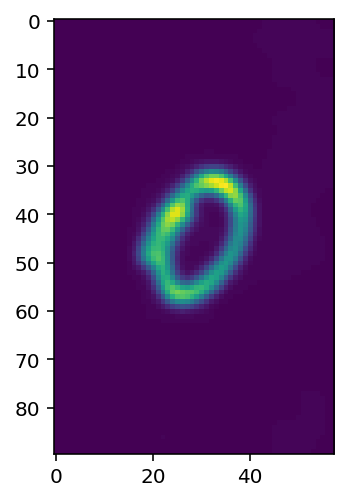

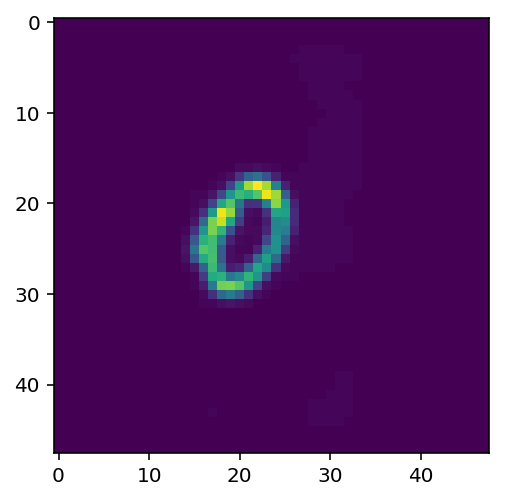

66.0


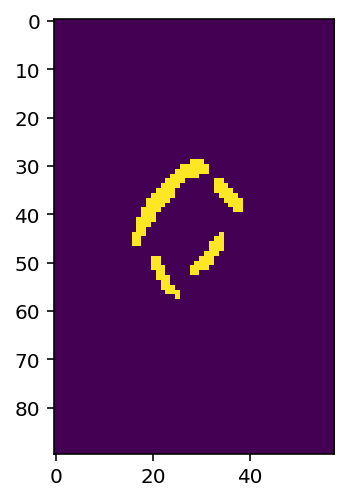

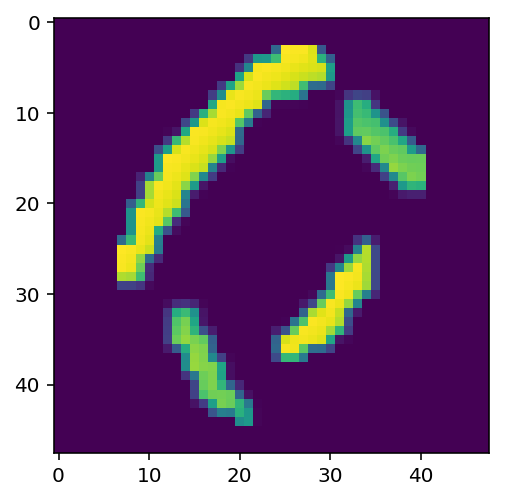

In [32]:
img = cv2.imread('testimg/%s/%s.jpg' % (0, 1), cv2.IMREAD_GRAYSCALE)
img = 255 - img
img = cv2.GaussianBlur(img, (7, 7), 0)
plt.imshow(img)
plt.show()
subimg = preprocessing(img)
plt.imshow(subimg)
plt.show()
img = img * preprocess(img)
img = preprocessing(img)
plt.imshow(img)
plt.show()

In [15]:
ret

NameError: name 'ret' is not defined